In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib as plb
import seaborn as sns
import scipy.stats as stats
import statistics
import dabest as db
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import shapiro, normaltest, kruskal, mannwhitneyu
from statsmodels.graphics.gofplots import qqplot

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Check for normality in mutant datasets
1. We first read in the datasets for each mutant screen
2. The datasets are the pooled worm positions for all replicates with >= 150 worms for each test condition.
3. To test for normality we use the Shapiro-Wilk test
4. Qualatitive test for normality by generating Q-Q plots

In [2]:
CX_x = pd.read_csv('D:/_2021_08_screen/S1fu/allReps_over150/150_CX10.csv', index_col=0)
PR_x = pd.read_csv('D:/_2021_08_screen/S1fu/allReps_over150/150_PR678.csv', index_col=0)


In [3]:
for column in CX_x.columns:
    dat = CX_x[column]
    length = len(CX_x[column])- len(CX_x[CX_x[column].isnull()])
    data = CX_x[column][:length]
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

Statistics=0.957, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.963, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.968, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.951, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.953, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.953, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.954, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.977, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.951, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.959, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.957, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.946, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.954, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.954, p=0.000
Sample does not look Gaussian (reject H0)
Statistics=0.956, p=0.000
Sample does not look G

C:\ProgramData\Anaconda3\envs\neuroplant\lib\site-packages\statsmodels\graphics\utils.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


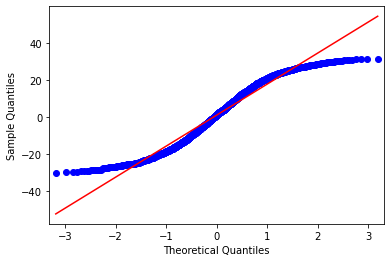

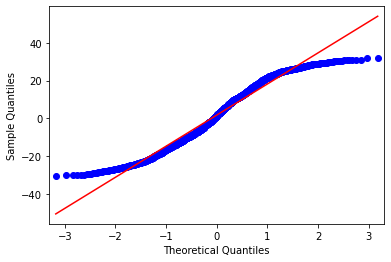

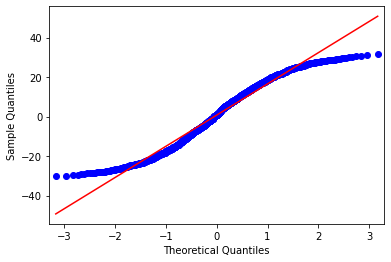

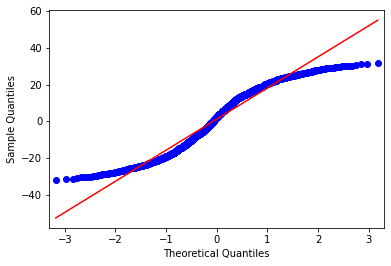

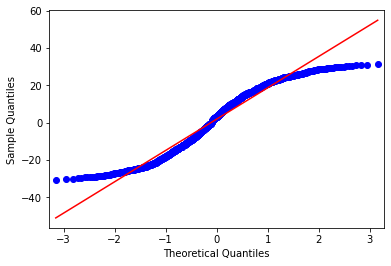

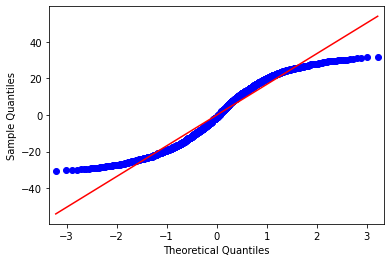

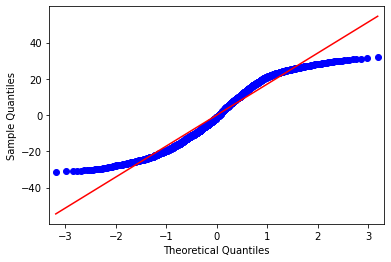

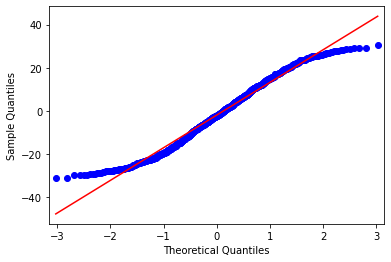

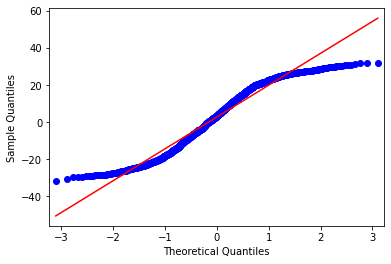

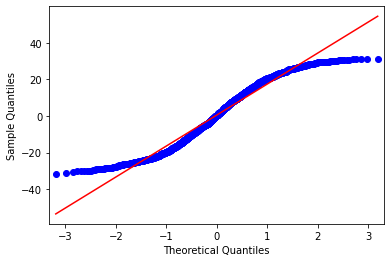

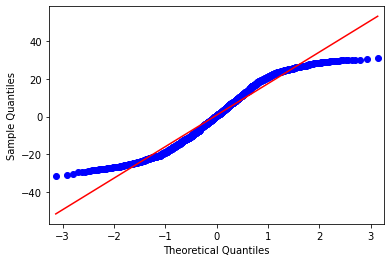

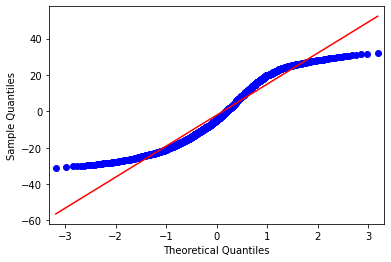

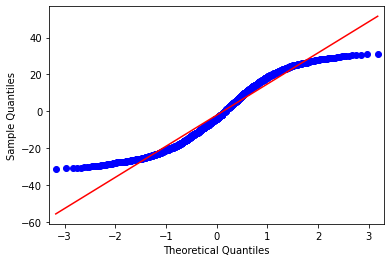

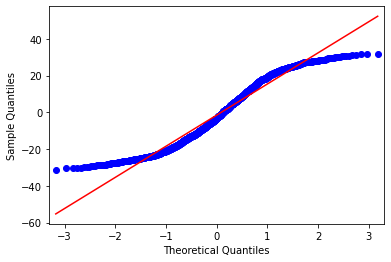

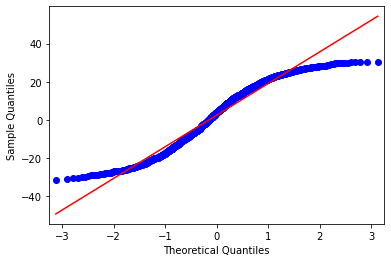

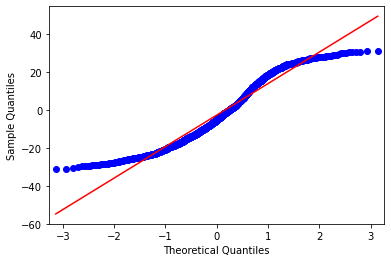

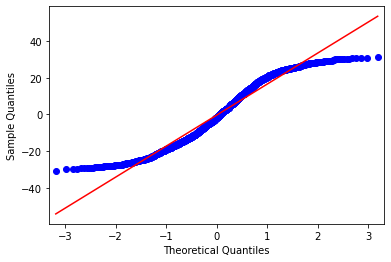

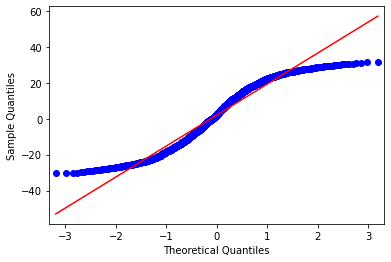

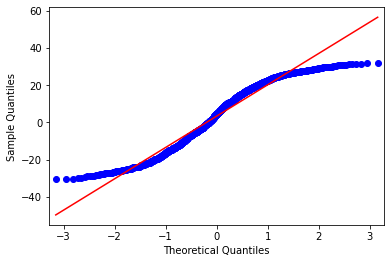

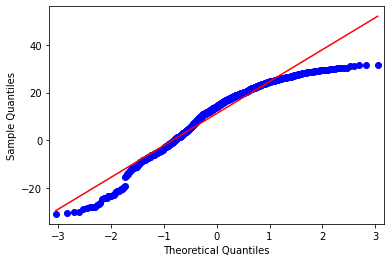

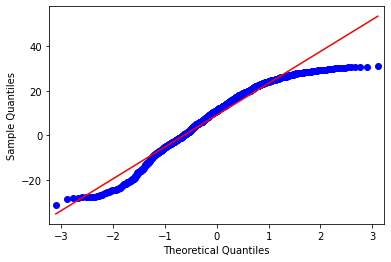

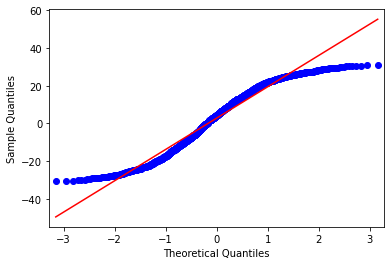

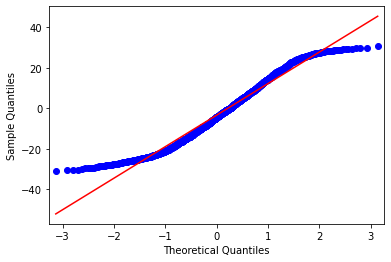

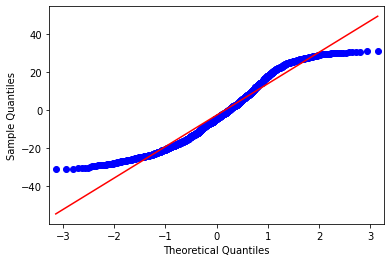

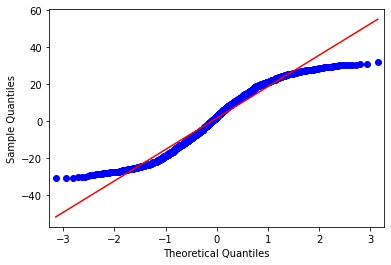

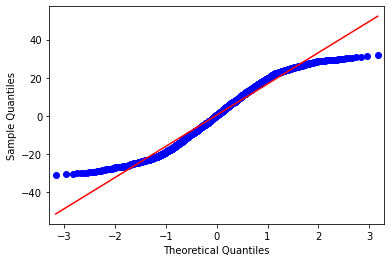

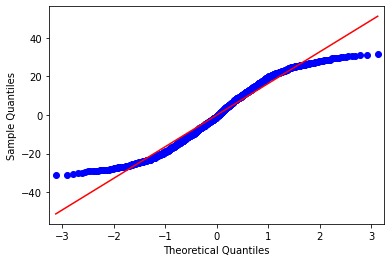

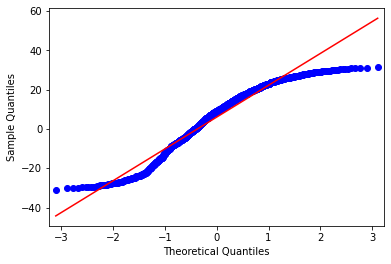

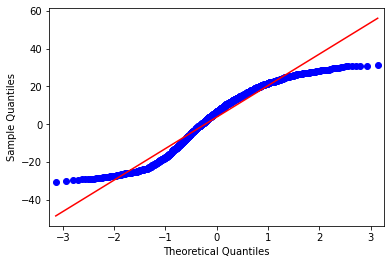

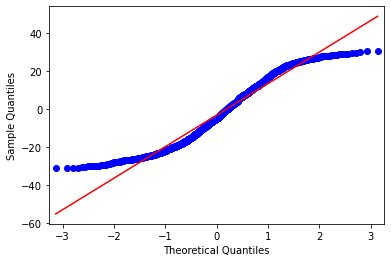

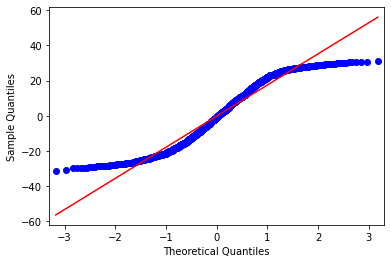

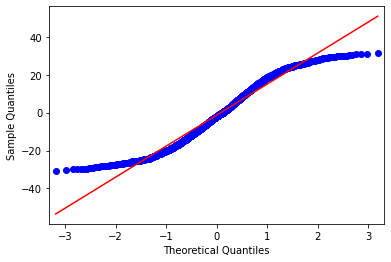

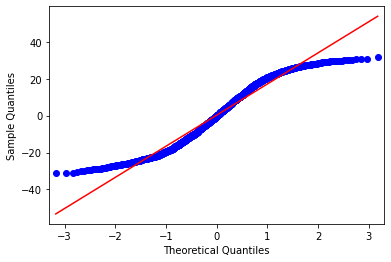

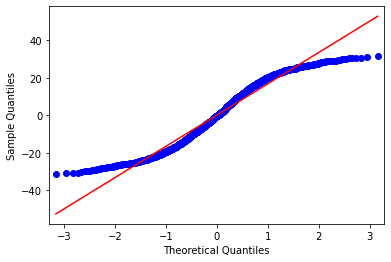

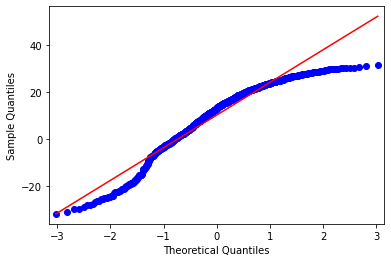

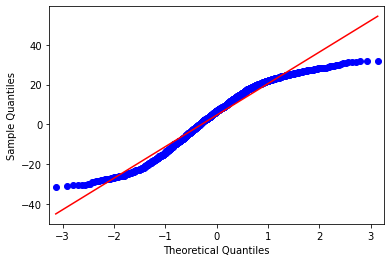

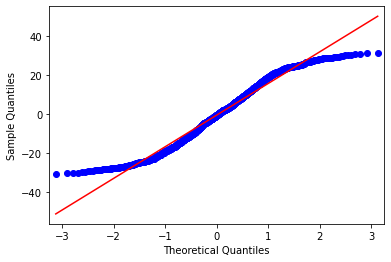

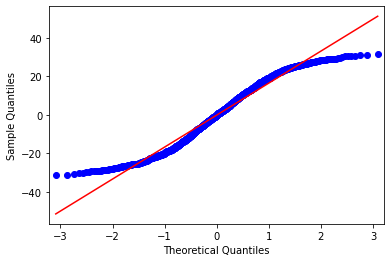

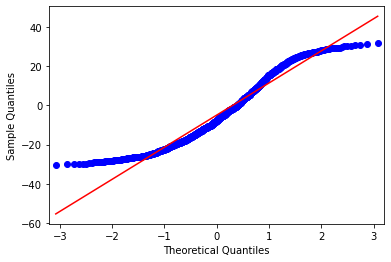

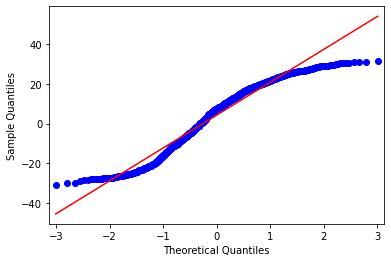

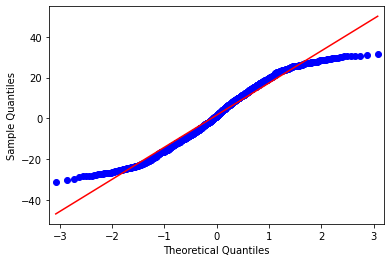

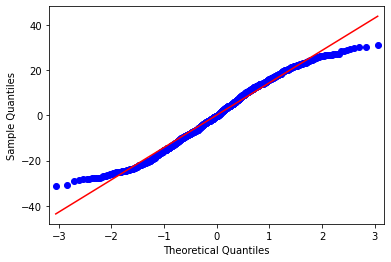

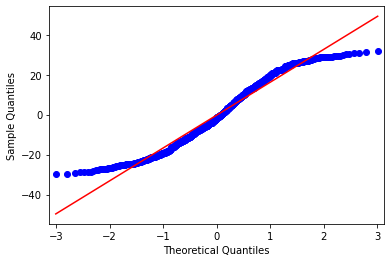

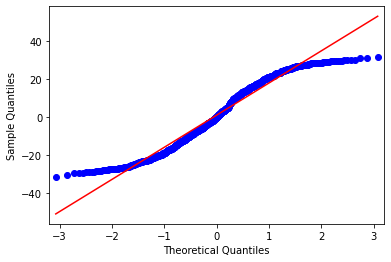

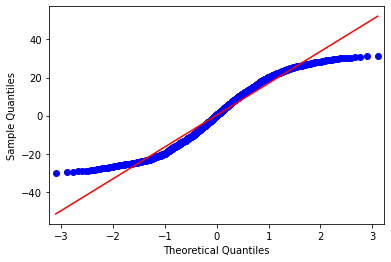

In [4]:
for column in CX_x.columns:
    dat = CX_x[column]
    length = len(CX_x[column])- len(CX_x[CX_x[column].isnull()])
    qqplot(CX_x[column][:length], line='s')
    

#### None of the datasets are found to have a normal distribution so we must invoke a non-parametric test: Mann-Whitney U
1. Reading in the N2 x position data to compare against

In [5]:
N2_xs = pd.read_csv('D:/_2021_08_screen/analysis/S1_xs.csv', index_col=0)
subset = ['control', 'test', 'test_N', 'difference', 'bca_low', 'bca_high']

2. We want to order our results based on the sorted order of the mean difference results presented in the analysis plots

In [6]:
def subset_refs(df, ref):
    dat = df.loc[df['control']== ref]
    dat =dat.sort_values('difference', ascending=False)
    dat = dat.reset_index(drop=True)
    return dat

In [7]:
N2dat = pd.read_csv('D:/_2021_08_screen/S1fu/N2_allrefs.csv', usecols=subset)
N2_DMSO_dat = subset_refs(N2dat, 'DMSO')
N2_DMSO_dat.loc[N2_DMSO_dat['test']=='H2O']
line = pd.DataFrame({"control": "DMSO", "test": "DMSO", 'test_N':"NaN", "difference":"NaN", "bca_low":"NaN", "bca_high":"NaN"}, index=[24])
all_N2dat = pd.concat([N2_DMSO_dat.iloc[:13], line, N2_DMSO_dat.iloc[13:]]).reset_index(drop=True)
N2_ord = all_N2dat['test'] 

3. Generating a function to remove NaN values and perform the Mann-Whitney U test to compare N2 response with mutant strain response using the pooled worm positions for each respective condition

In [8]:
def mwu(condition, df1, df2, strain):


    length1 = len(df1[condition])- len(df1[df1[condition].isnull()])
    data1 = df1[condition][:length1]

    length2 = len(df2[condition])- len(df2[df2[condition].isnull()])
    data2 = df2[condition][:length2]

    stat, p = mannwhitneyu(data1, data2)
    stats = {'Condition':condition, 'Strain': strain, 'Stat':stat, 'p-value': p}
    return stats

In [9]:
mwu_CX = pd.DataFrame()
comps = list(CX_x.columns)
for c in comps:
    data = mwu(c, CX_x, N2_xs, 'CX10')
    mwu_CX = mwu_CX.append(data, ignore_index=True)
#mwu_CX = mwu_CX.sort_values(by='p-value')

mwu_CX = mwu_CX.set_index('Condition')
mwu_CX = mwu_CX.reindex(N2_ord)
mwu_CX = mwu_CX.reset_index()

#mwu_CX.to_csv('D:/_2021_08_screen/analysis/mwu_CX.csv')

In [10]:
mwu_PR = pd.DataFrame()
comps = list(PR_x.columns)
for c in comps:
    data = mwu(c, PR_x, N2_xs, 'PR678')
    mwu_PR = mwu_PR.append(data, ignore_index=True)
#mwu_PR = mwu_PR.sort_values(by='p-value')
mwu_PR = mwu_PR.set_index('Condition')
mwu_PR = mwu_PR.reindex(N2_ord)
mwu_PR.head()
mwu_PR = mwu_PR.reset_index()

#mwu_PR.to_csv('D:/_2021_08_screen/analysis/mwu_PR.csv')


In [11]:
mwu_CX = mwu_CX.rename({'p-value': 'CX10 p'}, axis=1).drop(['Strain', 'Stat'], axis=1)
mwu_PR = mwu_PR.rename({'p-value': 'PR678 p'}, axis=1).drop(['Strain', 'Stat'], axis=1)
mwu_CXPR = mwu_CX.merge(mwu_PR, on='test')

#### We will combine all of the Mann-Whitney U values for our N2/PR678 and N2/CX10 data with the confidence intervals and mean differences previously computed against the means of DMSO and water

In [13]:
CX_md = pd.read_csv('D:/_2021_08_screen/S1fu/cx10_allrefs.csv', index_col=0).reset_index(drop=True)
PR_md = pd.read_csv('D:/_2021_08_screen/S1fu/PR678_allrefs.csv', index_col=0).reset_index(drop=True)

In [14]:
def add_mdiff(row, df, control):
    mdiff = df.loc[(df['test'] == row['test']) & (df['control']==control)]['difference']
    if len(mdiff)==0:
        return 'NaN'
    else:
        return mdiff.values[0]

mwu_CXPR['CX10 DMSO diff'] = mwu_CXPR.apply(
    lambda row: add_mdiff(row, CX_md, 'DMSO'), axis=1)
mwu_CXPR['CX10 H2O diff'] = mwu_CXPR.apply(
    lambda row: add_mdiff(row, CX_md, 'H2O'), axis=1)

mwu_CXPR['PR678 H2O diff'] = mwu_CXPR.apply(
    lambda row: add_mdiff(row, PR_md, 'H2O'), axis=1)
mwu_CXPR['PR678 DMSO diff'] = mwu_CXPR.apply(
    lambda row: add_mdiff(row, PR_md, 'DMSO'), axis=1)
mwu_CXPR.head()

,test,CX10 p,PR678 p,CX10 DMSO diff,CX10 H2O diff,PR678 H2O diff,PR678 DMSO diff
0,Isoamyl alcohol,4.018585e-04,3.754314e-70,11.588709,10.50143,-0.410686,3.405011
1,2-Methyl-1-butanol,5.887887e-03,1.929112e-38,10.463591,9.376312,-2.093066,1.722631
2,Thiophene,4.371294e-30,1.578965e-32,1.159964,0.072685,-0.890885,2.924812
3,"2,3-Dihydrobenzofuran",1.004970e-01,4.262685e-08,9.456101,8.368822,3.533378,7.349075
4,Diacetyl,2.898951e-13,1.911768e-01,2.800677,1.713398,5.631983,9.44768


In [20]:
def add_CI(row, df, control):
    l = df.loc[(df['test'] == row['test']) & (df['control']==control)]['bca_low']
    h = df.loc[(df['test'] == row['test']) & (df['control']==control)]['bca_high']
    if len(h) == 0:
        return 'NaN'
    else:
        interval = (l.values[0], h.values[0])
        return interval

mwu_CXPR['PR678 DMSO Interval'] = mwu_CXPR.apply(
    lambda row: add_CI(row, PR_md, 'DMSO'), axis=1)
mwu_CXPR['PR678 H2O Interval'] = mwu_CXPR.apply(
    lambda row: add_CI(row, PR_md, 'H2O'), axis=1)
mwu_CXPR['CX10 H2O Interval'] = mwu_CXPR.apply(
    lambda row: add_CI(row, CX_md, 'H2O'), axis=1)
mwu_CXPR['CX10 DMSO Interval'] = mwu_CXPR.apply(
    lambda row: add_CI(row, CX_md, 'DMSO'), axis=1)

In [22]:
mwu_CXPR['N2 DMSO Interval'] = mwu_CXPR.apply(
    lambda row: add_CI(row, N2dat, 'DMSO'), axis=1)
mwu_CXPR['N2 H2O Interval'] = mwu_CXPR.apply(
    lambda row: add_CI(row, N2dat, 'H2O'), axis=1)
mwu_CXPR['N2 H2O diff'] = mwu_CXPR.apply(
    lambda row: add_mdiff(row, N2dat, 'H2O'), axis=1)
mwu_CXPR['N2 DMSO diff'] = mwu_CXPR.apply(
    lambda row: add_mdiff(row, N2dat, 'DMSO'), axis=1)

In [37]:
mwu_CXPR.to_csv('D:/NP_manuscript/data/analysis_all_strains.csv')